In [6]:
#from google.colab import drive
#drive.mount('/content/drive')


In [7]:
#

### 목표
- 뇌종양(3가지 class),종양x, 총4가지 클래스를 분류하는 실습을 진행해보자
- 전이학습 모델 변경해보며, 각 모델 성능 비교

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#Maxpooling2D: 가장 강한 특징만 남김/ 있다. 없다. 에 민감
#Averagepooling2D: 전체 특징을 고르게 반영/ 부드럽고 안정적인 요약

#EfficientNetV2S
# tensorlFlow keras에서 제공하는 이미지 분류 모델중 하나
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.utils import image_dataset_from_directory
# 폴더에 저장된 이미지를 tensorflow dataset형식으로 불러오기 위한 유틸리티
# 폴더 구조에 따라 이미지를 자동으로 레이블링하고, 학습이나 평가에 사용할 수 있는 데이터셋으로 변환해줌


2026-01-15 09:01:57.610168: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-15 09:01:57.623992: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 09:01:58.112297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-15 09:02:00.332922: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computat

#### `tf.keras.applications`에서 제공하는 주요 모델
- applications Guide : https://www.tensorflow.org/api_docs/python/tf/keras/applications
- **모델명 · 설명 · ImageNet Top-1 정확도 · 파라미터 수(약)**  
- **입력 크기 224×224**(일부는 299×299) 기준  
- `include_top`, `weights`, `input_shape` 등을 조정하며, 필요에 따라 **특징 추출**, **미세 조정(fine-tuning)** 등 활용 가능  

---

### ConvNeXt 계열

- 출시 시기: 2022년 5월 (논문 발표 기준)

> 특징
> - Transformer 발전을 반영해 대형 커널 및 depth-wise conv로 설계
> - ResNet 구조를 현대화하여 단순화·고성능화 달성
> - Stage 구분과 채널 확장 비율 조정으로 성능/효율 균형 유지

> 🚩 큰 커널 사용으로 인해 메모리 소모가 증가할 수 있음.

| 모델명            | 설명                                     | Top-1 정확도 | 파라미터 수 |
|-------------------|------------------------------------------|-------------:|-----------:|
| **ConvNeXtTiny**  | 경량화된 ConvNeXt 버전, 빠른 추론 최적화  |    82.1%     |    28M    |
| **ConvNeXtSmall** | 중간 규모 모델, 성능/속도 균형 지향       |    83.1%     |    49M    |
| **ConvNeXtBase**  | 기본 모델, 논문 기준 밸런스 지점          |    83.8%     |    88M    |
| **ConvNeXtLarge** | 대형 모델, 높은 표현력                   |    84.0%     |   198M    |
| **ConvNeXtXLarge**| 초대형 모델, 최고 성능 지향               |    84.3%     |   350M    |

---

### DenseNet 계열

- 출시 시기: 2017년 3월 (CVPR 발표 기준)

> 특징
> - 각 층이 모든 이전 층의 출력을 입력으로 활용하는 Dense 연결
> - 그래디언트 흐름 개선과 파라미터 효율성 극대화
> - 비교적 적은 파라미터로 깊은 네트워크 구현 가능

> 🚩 Dense 연결로 인해 메모리 사용량 증가 가능성 존재.

| 모델명             | 설명                         | Top-1 정확도 | 파라미터 수 |
|--------------------|------------------------------|-------------:|-----------:|
| **DenseNet121**    | 121층, 각 블록 간 Dense 연결 |    74.0%     |     8M    |
| **DenseNet169**    | 169층, 더 깊은 연결망         |    75.3%     |    14M    |
| **DenseNet201**    | 201층, 최고 깊이 모델         |    77.0%     |    20M    |

---

### EfficientNet 계열

- 출시 시기: 2019년 5월 (ICML 발표 기준)

> 특징
> - depth, width, resolution을 균형 있게 확장하는 Compound Scaling
> - 작은 모델부터 대형 모델까지 일관된 설계 철학
> - 뛰어난 효율성과 성능을 동시에 달성

> 🚩 Compound Scaling 시 모델 크기 증가로 연산량이 크게 증가할 수 있음.

| 모델명           | 설명                           | Top-1 정확도 | 파라미터 수 |
|------------------|--------------------------------|-------------:|-----------:|
| **EfficientNetB0** | Baseline (작은 크기)          |    77.1%     |    5.3M   |
| **EfficientNetB1** | 중간 크기 ↑                   |    79.1%     |    7.8M   |
| **EfficientNetB2** | 추가 확장, 성능 향상 ↑        |    80.1%     |    9.2M   |
| **EfficientNetB3** | B2 대비 더 깊고 넓음          |    81.6%     |   12.0M   |
| **EfficientNetB4** | 고성능 추구, 크기↑            |    82.9%     |   19.0M   |
| **EfficientNetB5** | B4 대비 깊이 ↑                |    83.6%     |   30.0M   |
| **EfficientNetB6** | 더 큰 모델, 최고급 성능 지향  |    84.0%     |   43.0M   |
| **EfficientNetB7** | 최상위 모델                   |    84.3%     |   66.0M   |

---

### EfficientNetV2 계열
- 출시 시기: 2021년 6월 (ICLR 발표 기준)

> 특징
> - 초기 레이어에 Fused-MBConv 블록 도입해 빠른 학습 달성
> - Improved scaling strategy로 훈련/추론 속도 향상
> - Fused-MBConv 블록은 성능 향상을 위해 모델의 초기 레이어에 주로 배치됨

> 🚩 초기 Fused-MBConv 블록 사용으로 연산 최적화, 효율성 향상.

| 모델명             | 설명                             | Top-1 정확도 | 파라미터 수 |
|--------------------|----------------------------------|-------------:|-----------:|
| **EfficientNetV2B0** | V2 초기 모델                   |    82.3%     |    8.0M   |
| **EfficientNetV2B1** | B0 대비 확장                   |    83.4%     |    9.0M   |
| **EfficientNetV2B2** | 더 깊고 넓어진 구조            |    83.7%     |    9.1M   |
| **EfficientNetV2B3** | B2 대비 성능↑                  |    84.3%     |   11.0M   |
| **EfficientNetV2S**  | Small 버전, 속도 최적화        |    83.3%     |   22.1M   |
| **EfficientNetV2M**  | Medium, 밸런스 모델            |    85.1%     |   54.4M   |
| **EfficientNetV2L**  | Large, 고성능 모델             |    85.6%     |   88.0M   |

---

### Inception 계열

- 출시 시기: 2015~2017년

> 특징
> - 다양한 크기 필터를 병렬 결합 (Inception)
> - Depthwise Separable Conv로 연산 효율화 (Xception)

| 모델명                  | 설명                                       | Top-1 정확도 | 파라미터 수 |
|-------------------------|--------------------------------------------|-------------:|-----------:|
| **InceptionV3**         | 모듈화된 병렬 컨볼루션 블록                 |    77.9%     |   23.9M   |
| **Xception**            | Depthwise Separable Conv를 확장 적용        |    79.0%     |   22.9M   |

---

### ResNet 계열
- 출시 시기: 2015~2016년

> 특징
> - 스킵 연결(residual connection)으로 매우 깊은 네트워크 학습 가능  
> - V2는 BatchNorm→Activation 순서 개선  
> - 다양한 깊이(50/101/152)로 모델 선택 용이

| 모델명               | 설명                                          | Top-1 정확도 | 파라미터 수 |
|----------------------|-----------------------------------------------|-------------:|-----------:|
| **ResNet50**         | 50층, 기본 스킵 연결                           |    76.0%     |   25.6M   |
| **ResNet101**        | 101층, 더 깊은 구조                           |    77.0%     |   44.6M   |
| **ResNet152**        | 152층, 최고 깊이                              |    77.6%     |   60.2M   |
| **ResNet50V2**       | 개선된 BatchNorm 이후 활성화 순서             |    77.0%     |   25.6M   |
| **ResNet101V2**      | V2 방식으로 확장                             |    77.9%     |   44.5M   |
| **ResNet152V2**      | V2 방식 최고 깊이                            |    78.0%     |   60.2M   |

---

### VGG 계열

- 출시 시기: 2014년 9월
> **특징**  
> - 연속된 3×3 컨볼루션 블록으로 단순하지만 깊은 구조  
> - 매우 큰 파라미터 수로 메모리 사용량 높음  
> - 초기 CNN 연구의 기준 모델

| 모델명    | 설명                    | Top-1 정확도 | 파라미터 수 |
|-----------|-------------------------|-------------:|-----------:|
| **VGG16** | 16층, 연속 3×3 Conv 사용 |    71.5%     |  138.4M   |
| **VGG19** | 19층, 더 깊어진 버전     |    71.3%     |  143.7M   |

---

### MobileNet 계열
- **특징**  
  - Depthwise Separable Convolution으로 경량화  
  - 낮은 연산량으로 모바일/엣지 환경에 최적  
  - V2는 Inverted Residual, V3는 NAS로 구조 탐색

| 모델명               | 설명                                      | Top-1 정확도 | 파라미터 수 |
|----------------------|-------------------------------------------|-------------:|-----------:|
| **MobileNet**        | Depthwise Separable Conv 기반 경량화 모델 |    70.6%     |    4.2M   |
| **MobileNetV2**      | Inverted Residual + Linear Bottleneck      |    71.8%     |    3.4M   |
| **MobileNetV3Small** | NAS로 설계한 초경량 Small 버전             |    62.3%     |    1.6M   |
| **MobileNetV3Large** | NAS 설계한 고성능 Large 버전               |    75.2%     |    5.4M   |

---

### NASNet 계열
- **특징**  
  - Neural Architecture Search(NAS)로 자동 설계  
  - Mobile/Large 두 가지 용도별 모델 제공  
  - 연산 효율과 성능 최적화 간 균형 지향

| 모델명               | 설명                                      | Top-1 정확도 | 파라미터 수 |
|----------------------|-------------------------------------------|-------------:|-----------:|
| **NASNetMobile**     | Mobile 환경용 NAS 설계                     |    74.0%     |    5.3M   |
| **NASNetLarge**      | 고성능 서버용 NAS 설계                     |    82.7%     |   88.9M   |

---


# npz 데이터 로딩
-압축된 형식의 배열로 저장:npz
-대용량의 데이터를 합축형태로 정리해두면 쉽게 업로드 다운로드
- 저장소공간 효율좋음

In [2]:
data=np.load('/home/hyuksu/projects/ml/bootcampdeeplearning/data/brain_tumor_data.npz')

In [3]:
data.keys()

KeysView(NpzFile '/home/hyuksu/projects/ml/bootcampdeeplearning/data/brain_tumor_data.npz' with keys: X_train, X_test, y_train, y_test, DESC)

In [4]:
print(data['DESC'])

[brain_tumor_dataset] 24.01.22 created by sjy, data from kaggle
                    name of classes:
                    - [0-'glioma_tumor', 1- 'meningioma_tumor', 2- 'no_tumor',3- 'pituitary_tumor']
                    - glioma tumor 신경교종: 뇌와 척수의 내부에 있는 신경교세포에서 기원하는 종양
                    - meningioma tumor 뇌수막종: 뇌를 둘러싸고 있는 지주막 세포에서 기원하는 종양
                    - no_tumor 종양x
                    - pituitary adenoma 뇌하수체 종양: 뇌 조직 중 호르몬 분비를 담당하는 뇌하수체에 발생하는 모든 양성 종양

                    data info
                    - X_train2: (2870, 224, 224, 3)
                    - y_train2: (2870, 4)
                    - X_test2: (394, 224, 224, 3)
                    - y_test2: (394, 4)
                    


- [0-'glioma_tumor', 1- 'meningioma_tumor', 2- 'no_tumor',3- 'pituitary_tumor']
                    - glioma tumor 신경교종: 뇌와 척수의 내부에 있는 신경교세포에서 기원하는 종양
                    - meningioma tumor 뇌수막종: 뇌를 둘러싸고 있는 지주막 세포에서 기원하는 종양
                    - no_tumor 종양x
                    - pituitary adenoma 뇌하수체 종양: 뇌 조직 중 호르몬 분비를 담당하는 뇌하수체에 발생하는 모든 양성 종양

                    data info
                    - X_train2: (2870, 224, 224, 3)
                    - y_train2: (2870, 4)
                    - X_test2: (394, 224, 224, 3)
                    - y_test2: (394, 4)
                    

In [5]:
# 데이터 각각의 변수에 담아주기
train_x=data['X_train']
train_y=data['y_train']
test_x=data['X_test']
test_y=data['y_test']

In [6]:
# 크기 확인
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2870, 224, 224, 3)
(2870, 4)
(394, 224, 224, 3)
(394, 4)


In [7]:
# 랜덤하게 인덱스를 선택해서 이미지를 출력해보기
import numpy as np
np.random.seed(42)
rd_list=np.random.randint(low=0,high=len(train_x),size=20)
pick=rd_list[0:4]

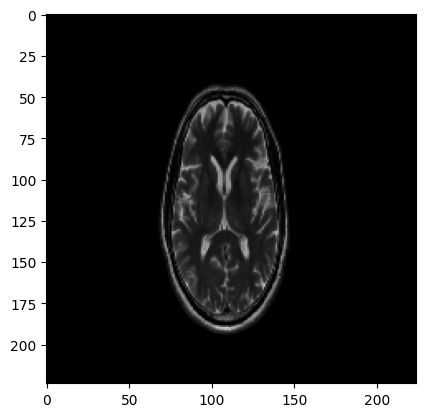

In [8]:
train_x[rd_list]

plt.imshow(train_x[860].astype('uint8'))
#부동소수점 0~1 사이의 값 또는 (0~255깂)으로 맞춰 imshow 가능
plt.show()

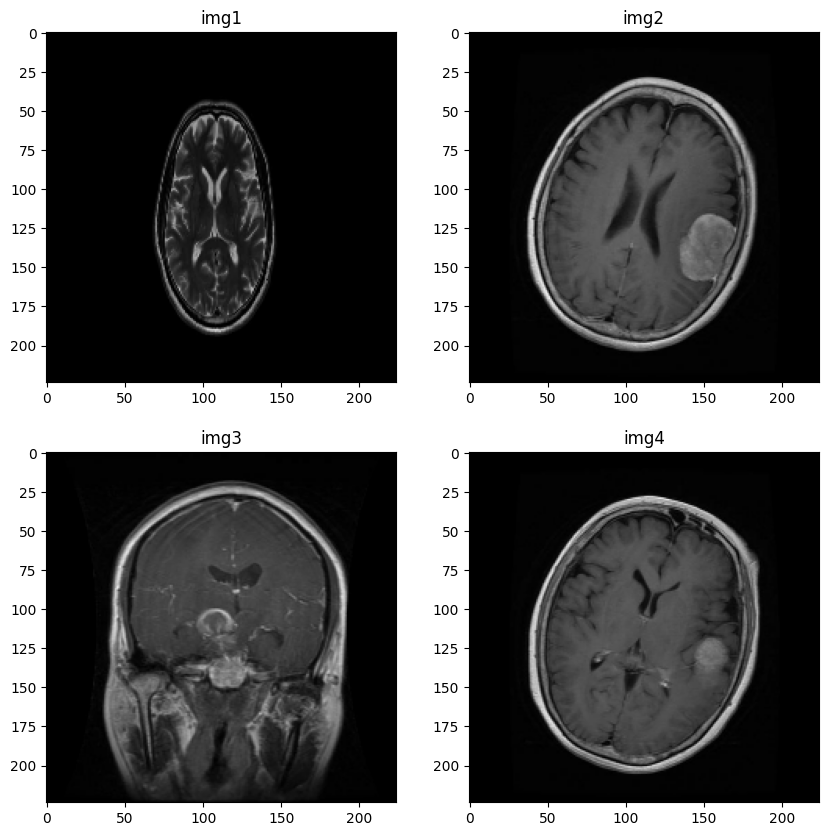

In [9]:
# train_x 에서 이미지를 가저와서 unit8(이미지 표준 타입)으로 변환
img1, img2, img3, img4 = train_x[pick].astype('uint8')

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('img1')
plt.imshow(img1)


plt.subplot(2,2,2)
plt.title('img2')
plt.imshow(img2)

plt.subplot(2,2,3)
plt.title('img3')
plt.imshow(img3)

plt.subplot(2,2,4)
plt.title('img4')
plt.imshow(img4)

plt.show()

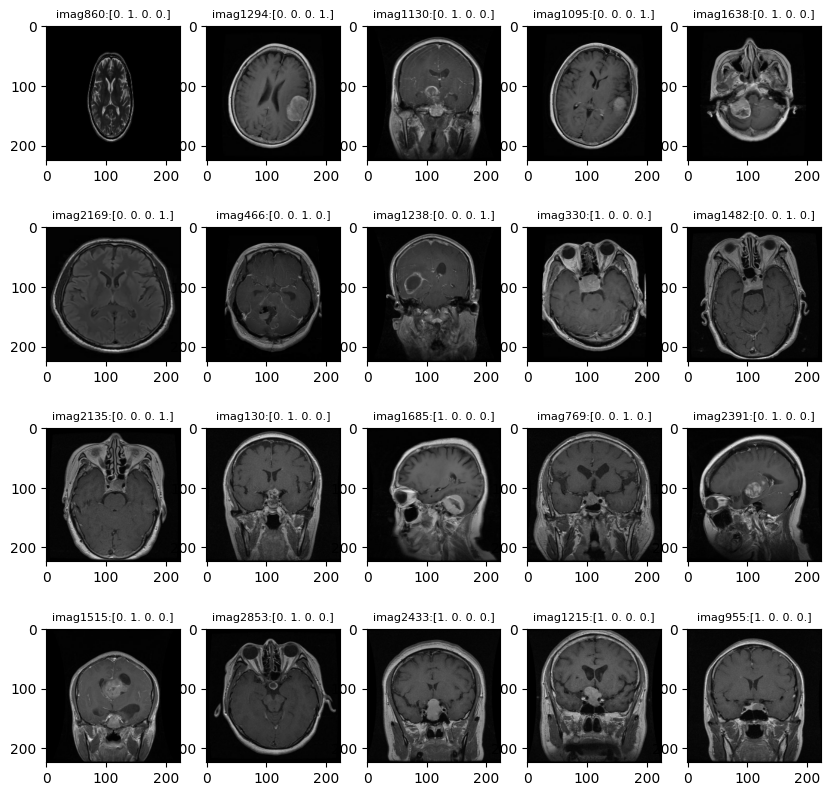

In [10]:
plt.figure(figsize=(10,10))
#이미지를 표시할때 사용할 카운터 변수 초기화

cnt=1
for i in range(len(rd_list)):
  # 4*5 격자(총20칸) 중에 cnt번쨰 위치에 서브플롯 생성
  plt.subplot(4,5,cnt)

  plt.axis('on')
  #서브플롯의 제목을 설정
  # 제목은 rd_list의 i번쨰 인덱스와 해당 인덱스에 해당하는 y_train을 기입
  plt.title(f'imag{rd_list[i]}:{train_y[i]}',fontdict={'fontsize':8})
  plt.imshow(train_x[rd_list[i]].astype('int32'))
  cnt+=1
plt.show()

### 이미지 특성추출 도구 생성
  - 전이학습 진행
  - 사전 훈련 모델 가저오기

In [16]:
from matplotlib import image
#EfficientNetV2S 모델을 초기화하여 image_prepro 변수에 저장
#이 모델은 사전 훈련된 가중치(imagenet에서 훈련된 가중치)를 사용하여, 모델의 분류 레이어는 포함하지 않음
#이 모델은 특징에 추출을 위한 베이스 모델로 활용
image_prepro=EfficientNetV2S(include_top=False,#모델 분류기 부분은 제외함
                             input_shape=(224,224,3),weights='imagenet', #모델의가중치는 imagenet 데이터셋으로 사전훈련된 가중치를 사용한다

                             pooling='max')

In [17]:
image_prepro.trainable=False
#특성 추출방식
tumor_model=Sequential()
#특성 추출부
tumor_model.add(image_prepro)
# 분류뷰
tumor_model.add(Dense(256,activation='relu'))
tumor_model.add(Dropout(0.5))
tumor_model.add(Dense(128,activation='relu'))
tumor_model.add(Dropout(0.5))
tumor_model.add(Dense(4,activation='softmax'))
tumor_model.summary()

# efficientnetv2
#output:(None,1280)
#param: 20.331.360
#none 배치크기
#1280차원

#dense
#output: (none,256)
#param:327936
#efficientnetv2이 추출한 1280 차원의 특징을
# 258차원으로 압축하는 분류기 첫 Dense레이어
# 1280 *256 +256(bias)
# 비선형함수 relu를 사용하여 activation사용

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,692,708 (78.94 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [18]:
# 컴파일 - 다중분류
tumor_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
# 조기학습 중단 설정값

ealry=EarlyStopping(monitor='val_loss',patience=5,verbose=1)
#학습
# 검증 0.2 반복 20 조기학습 중단 연결, 배치사이즈 16
# 학습현황 h 변수 답기
h=tumor_model.fit(train_x,train_y,validation_split=0.2,epochs=20,batch_size=16,callbacks=[ealry])

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 709ms/step - accuracy: 0.3942 - loss: 1.7773 - val_accuracy: 0.6324 - val_loss: 1.0146
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 98s 681ms/step - accuracy: 0.5248 - loss: 1.0630 - val_accuracy: 0.6847 - val_loss: 0.7871
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 135s 634ms/step - accuracy: 0.5936 - loss: 0.9269 - val_accuracy: 0.7247 - val_loss: 0.6980
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 96s 666ms/step - accuracy: 0.6111 - loss: 0.8764 - val_accuracy: 0.7334 - val_loss: 0.6739
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 98s 681ms/step - accuracy: 0.6202 - loss: 0.8482 - val_accuracy: 0.7596 - val_loss: 0.6222
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 93s 649ms/step - accuracy: 0.6564 - loss: 0.8171 - val_accuracy: 0.7753 - val_loss: 0.5662
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 99s 685ms/step - accuracy: 0.6951 - loss: 0.7526 - val_accuracy: 0.7857 - val_loss: 0.5658
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 95s 662ms/step - accuracy: 0.6899 - loss:

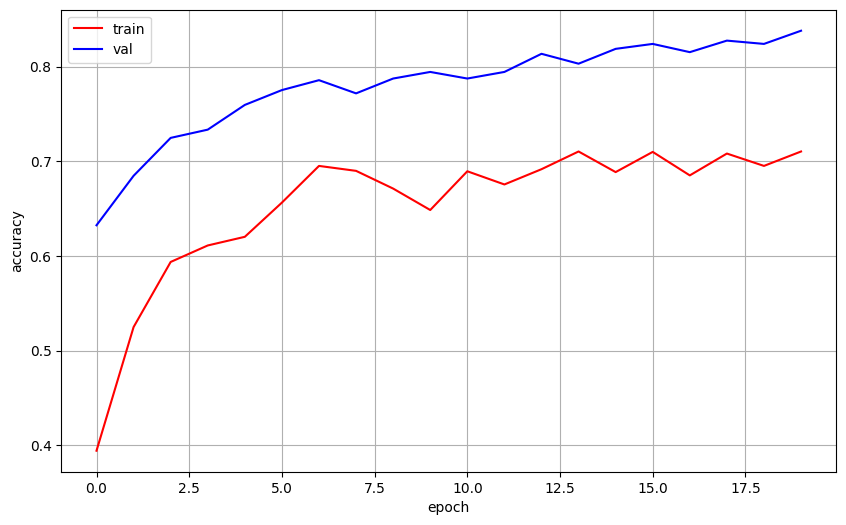

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(h.history['accuracy'],label='train',color='red')
plt.plot(h.history['val_accuracy'],label='val',color='blue')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.show()


In [22]:
tumor_model.predict(test_x)

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 782ms/step


array([[0.22236969, 0.38131577, 0.08279273, 0.3135219 ],
       [0.3242233 , 0.3762741 , 0.11945435, 0.1800483 ],
       [0.2989671 , 0.49698836, 0.07758583, 0.12645869],
       ...,
       [0.28767824, 0.38908923, 0.10115442, 0.22207813],
       [0.17387469, 0.7032458 , 0.09596042, 0.02691912],
       [0.01389334, 0.10389862, 0.00207431, 0.8801337 ]],
      shape=(394, 4), dtype=float32)

In [23]:
tumor_model.evaluate(test_x,test_y)

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 576ms/step - accuracy: 0.6193 - loss: 0.9835


[0.9834845066070557, 0.6192893385887146]

In [13]:
from tensorflow.keras.models import load_model
instance=load_model('/home/hyuksu/projects/ml/bootcampdeeplearning/data/model/transition_model_brain_tumor_effv2.keras')

In [14]:
a=instance.predict(test_x)


13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 


In [15]:
instance.evaluate(test_x,test_y)

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 725ms/step - accuracy: 0.6193 - loss: 0.9835


[0.9834845066070557, 0.6192893385887146]